### 러닝스파크 p71

## 1. 필요 라이브러리 및 데이터 호출

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter 환경에서 대화형 그래프 활성화
%matplotlib widget

In [2]:
sc = SparkSession.builder.appName('spark').getOrCreate()
sc

24/12/11 15:46:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
df = sc.read.csv('data/sf-fire-calls.csv', header = True)
df.printSchema()

root
 |-- CallNumber: string (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: string (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- AvailableDtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPriority: string (nullable = true)
 |-- ALSUnit: string (nullable = true)
 |-- CallTypeGroup: string (nullable = true)
 |-- NumAlarms: string (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- UnitSequenceInCallDispatch: string (nullable = true)
 |-- FirePreventionDistrict: string (nullable = true)
 |-- Sup

In [4]:
df.selectExpr('*').show(3)

24/12/11 15:46:38 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+------+--------------+----------------+----------+----------+--------------------+--------------------+--------------------+----+-------+---------+-----------+----+----------------+--------+-------------+-------+-------------+---------+--------+--------------------------+----------------------+------------------+--------------------+--------------------+-------------+---------+
|CallNumber|UnitID|IncidentNumber|        CallType|  CallDate| WatchDate|CallFinalDisposition|       AvailableDtTm|             Address|City|Zipcode|Battalion|StationArea| Box|OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumAlarms|UnitType|UnitSequenceInCallDispatch|FirePreventionDistrict|SupervisorDistrict|        Neighborhood|            Location|        RowID|    Delay|
+----------+------+--------------+----------------+----------+----------+--------------------+--------------------+--------------------+----+-------+---------+-----------+----+----------------+--------+------------

## 2. 전처리

In [5]:
# 임시테이블 정의
df.createOrReplaceTempView('temp_table')

sc.sql('''
        select * from temp_table
        '''
      )


DataFrame[CallNumber: string, UnitID: string, IncidentNumber: string, CallType: string, CallDate: string, WatchDate: string, CallFinalDisposition: string, AvailableDtTm: string, Address: string, City: string, Zipcode: string, Battalion: string, StationArea: string, Box: string, OriginalPriority: string, Priority: string, FinalPriority: string, ALSUnit: string, CallTypeGroup: string, NumAlarms: string, UnitType: string, UnitSequenceInCallDispatch: string, FirePreventionDistrict: string, SupervisorDistrict: string, Neighborhood: string, Location: string, RowID: string, Delay: string]

### 2.1 NULL 확인(뒤에 하다보니 NULL값이 있음)

In [6]:
sc.sql('''
    select 
    A.`NULL 개수`
    , B.`NULL 포함 전체 데이터 개수`
    , round((A.`NULL 개수` / B.`NULL 포함 전체 데이터 개수`) * 100,2) as `NULL 비율`
    from 
                (select
                    count(*) as `Null 개수`
                from temp_table
                where city is null
                ) as A
    inner join (select
                    count(*) as `NULL 포함 전체 데이터 개수`
                    from temp_table
                ) as B
    on 1 = 1    
''').show()


+---------+--------------------------+---------+
|NULL 개수|NULL 포함 전체 데이터 개수|NULL 비율|
+---------+--------------------------+---------+
|      207|                    175296|     0.12|
+---------+--------------------------+---------+



### 2.2 NULL의 비중이 낮으니, 그냥 drop하는 것으로 결정

In [7]:
df_null_except = sc.sql('''
                        select * from temp_table
                        where city is not null
                        ''')\

df_null_except.createOrReplaceTempView('temp_table_2')

### 2.3 city에 축약과 FullName이 섞여있어, FullName으로 통일시켜주기

In [8]:
# city 컬럼 확인
sc.sql('''
    select
    distinct city
    from temp_table_2
    where length(city) <= 3
    '''
)\
.show()

sc.sql('''
    select
    distinct city
    from temp_table_2
    -- where length(city) <= 3
    '''
)\
.show()

+----+
|city|
+----+
| OAK|
|  DC|
|  TI|
|  HP|
|  YB|
|  BN|
|  SF|
|  FM|
| SFO|
|  PR|
+----+

+---------------+
|           city|
+---------------+
|     FORT MASON|
|     Fort Mason|
|            OAK|
|             DC|
|             TI|
|TREASURE ISLAND|
|  San Francisco|
|             HP|
|             YB|
|             BN|
|       Brisbane|
|      Daly City|
|    Yerba Buena|
|Treasure Island|
|             SF|
|       PRESIDIO|
|       Presidio|
|             FM|
|            SFO|
|  Hunters Point|
+---------------+
only showing top 20 rows



In [9]:
# 임시 테이블 삭제 구문
# sc.catalog.dropTempView('temp_table_3')

sc.sql('''
    select
        *
    from (
        select
         CallNumber,
         UnitID,
         IncidentNumber,
         CallType,
         CallDate,
         WatchDate,
         CallFinalDisposition,
         AvailableDtTm,
         Address,
         Case when city = 'DC' THEN  upper('Daly City')
                when city = 'SF' THEN upper('San Francisco')
                when city = 'FM' THEN upper('FORT MASON')
                when city = 'TI' THEN upper('TREASURE ISLAND')
                when city = 'YB' THEN upper('Yerba Buena')
                when city = 'BN' THEN upper('BRISBANE')
                when city = 'HP' THEN upper('Hunters Point')
                when city = 'PR' THEN upper('PRESIDIO')
                else upper(city) END as city_full,
         Zipcode,
         Battalion,
         StationArea,
         Box,
         OriginalPriority,
         Priority,
         FinalPriority,
         ALSUnit,
         CallTypeGroup,
         NumAlarms,
         UnitType,
         UnitSequenceInCallDispatch,
         FirePreventionDistrict,
         SupervisorDistrict,
         Neighborhood,
         Location,
         RowID,
         Delay
        from temp_table_2
    ) as A
    ''')\
.createOrReplaceTempView('temp_table_3')

## 3. 데이터 분석

### 2018년에 왔던 신고 전화들의 모든 유형은 어떤 것이었는가?

In [10]:
sc.sql('''
    SELECT
    
        right(CallDate,4) as date_year
        , CallType
        , count(CallType) as cnt_calltype
    from
    temp_table_3
    -- where right(CallDate,4) = 2018
    Group by right(CallDate,4), CallType
    having right(CallDate,4) = 2018
    order by 3 desc
    ''').show()

+---------+--------------------+------------+
|date_year|            CallType|cnt_calltype|
+---------+--------------------+------------+
|     2018|    Medical Incident|        6990|
|     2018|              Alarms|        1144|
|     2018|      Structure Fire|         904|
|     2018|   Traffic Collision|         431|
|     2018|        Outside Fire|         153|
|     2018|               Other|         114|
|     2018|Citizen Assist / ...|         113|
|     2018|Gas Leak (Natural...|          69|
|     2018|        Water Rescue|          43|
|     2018|Elevator / Escala...|          36|
|     2018|   Electrical Hazard|          30|
|     2018|Smoke Investigati...|          28|
|     2018|        Vehicle Fire|          27|
|     2018|          Fuel Spill|          10|
|     2018|Odor (Strange / U...|          10|
|     2018|              HazMat|           5|
|     2018|Train / Rail Inci...|           5|
|     2018|  Suspicious Package|           3|
|     2018|           Explosion|  

### 2018년 신고 전화가 가장 많았던 달은 언제인가?

In [11]:
sc.sql('''
    SELECT
        split(CallDate, '/')[0] as month --월만 인덱싱 이게 되네
        , count(CallDate) as cnt_CallDate_month
        from
        temp_table_3
    where right(CallDate,4) = 2018
    group by 1
    order by 2 desc
    limit 1 -- 상위 1개만 추출

    ''')\
.show()

+-----+------------------+
|month|cnt_CallDate_month|
+-----+------------------+
|   10|              1068|
+-----+------------------+



### 2018년에 가장 많은 신고가 들어온 샌프란시스코 지역

In [12]:
sc.sql('''
    Select
    Address
    , count(Address)
    from
        (
        SELECT
            Address
            , city_full as count_city       
        FROM
        temp_table_3
        where right(CallDate,4) = 2018
            and city_full = upper('San Francisco')
        )    
    group by Address
    order by 2 desc
    '''
      )\
.show()


+--------------------+--------------+
|             Address|count(Address)|
+--------------------+--------------+
|   0 Block of 6TH ST|            62|
|800 Block of MARK...|            62|
|300 Block of EDDY ST|            58|
| 500 Block of 5TH ST|            58|
|400 Block of ELLI...|            55|
|1100 Block of MAR...|            55|
|1000 Block of POL...|            46|
|100 Block of EDDY ST|            46|
| 100 Block of 6TH ST|            39|
|1100 Block of MIS...|            38|
|200 Block of EDDY ST|            33|
|1200 Block of TUR...|            32|
|300 Block of ELLI...|            32|
|900 Block of GEAR...|            31|
|200 Block of GOLD...|            30|
|400 Block of EDDY ST|            29|
|500 Block of SOUT...|            29|
|300 Block of SILV...|            29|
|600 Block of VALE...|            29|
|500 Block of MARK...|            28|
+--------------------+--------------+
only showing top 20 rows



### 2018년에 가장 응답 시간이 늦었던 지역

In [13]:
sc.sql('''
    select
        city_full
        , round(max(delay), 2) as max_delay
    from temp_table_3
    where right(CallDate,4) = 2018
    group by city_full
    order by 2 desc
    limit 1
    
    '''
)\
.show()

+-------------+---------+
|    city_full|max_delay|
+-------------+---------+
|SAN FRANCISCO|    94.72|
+-------------+---------+



#### 2018년 어떤 주에서 신고가 제일 많았는가?

In [14]:
sc.sql('''
    select
        city_full
        , count(city_full)
    from
    temp_table_3
    group by city_full
    order by 2 desc
    limit 1
    ''')\
.show()


+-------------+----------------+
|    city_full|count(city_full)|
+-------------+----------------+
|SAN FRANCISCO|          173487|
+-------------+----------------+



#### 지역, 우편번호, 신고 숫자 간에 상관관계가 있는가?

In [15]:
df_temp = sc.sql('''
    select
    city_full
    , count(zipcode) as count_zipcode_by_city
    , count(city_full) as count_singo_by_city
    from
    temp_table_3
    --where city_full != upper('san francisco')
    group by city_full
    order by city_full
    '''
  )

df_temp1 = df_temp.toPandas()

In [16]:
df_temp1

,city_full,count_zipcode_by_city,count_singo_by_city
0,BRISBANE,4,12
1,DALY CITY,17,50
2,FORT MASON,73,73
3,HUNTERS POINT,58,58
4,OAK,9,11
5,PRESIDIO,551,551
6,SAN FRANCISCO,173431,173487
7,SFO,0,37
8,TREASURE ISLA,228,228
9,TREASURE ISLAND,507,507


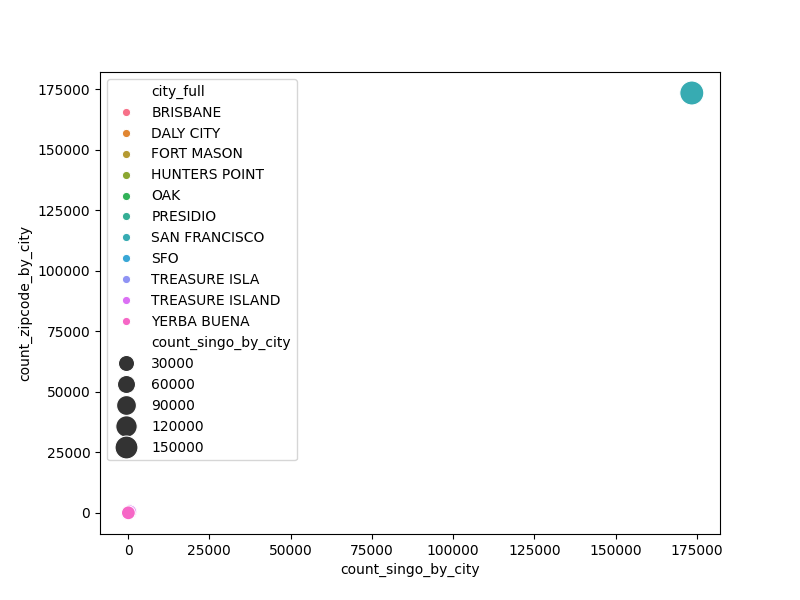

In [17]:
# 기본 폰트 설정
plt.rcParams['font.family'] = 'sans-serif'
plt.figure(figsize=(8,6))

sns.scatterplot(data = df_temp1
                , x = df_temp1['count_singo_by_city']
                , y = df_temp1['count_zipcode_by_city']
                , hue = df_temp1['city_full']
                , size = df_temp1['count_singo_by_city'] #뭘 기준으로 사이즈 측정할껀지 선택
                , sizes = (100,300) #사이즈의 최소, 최대 사이즈라고 함                
               )
plt.show()

### 분석 결과

<span style="background-color:#fff5b1;
color : black;
font-weight : bold;">
우편번호</span>
, <span style="background-color:#fff5b1;
color : black;
font-weight : bold;">신고건수</span>
는 <span style="background-color:#fff5b1;
color : black;
font-weight : bold;">
양의 상관관계</span>를 가지는 것으로 보인다.

즉, 신고건수가 많아질 수록 지역별로 안의 우편번호의 개수도 증가하는 것으로 보인다.

<span style="background-color:#fff5b1;
            color : black;
            font-weight : bold;">
            특이점</span><br>
샌프란시스코의 건수가 타 지역보다 월등히 많다
<table>
    <tr>
        <th style = 'text-align : center;'>ZipCode개수</th>    
        <th style = 'text-align : center;'>신고건수</th>
    </tr>
    <tr>
        <td style = 'text-align : center;'>173,431</td>
        <td style = 'text-align : center;'>173,487</td>
    </tr>
</table>

하지만 이 역시도 다른 지역과 연계해서 보았을때 차트 전체가 <span style="background-color:#fff5b1;
            color : black;
            font-weight : bold;">
            우상향</span>하는 그래프임을 알 수 있다.

In [18]:
sc.stop()